<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**ALGORITMOS** -
Prof: Carmen Pellicer Lostao

# Optimizacion cuantica con algoritmos variacionales (VQE y QAOA)

## Introduccion a la Optimizacion en Qiskit

Muchos problemas prácticos en varios campos son problemas de optimización y tienen amplia aplicacion en diferentes problemas de empresa.

Los problemas de optimización se encuentran en el centro de la compleja toma de decisiones y definición de estrategias.

Son problemas de búsqueda de una solución óptima en un conjunto finito o contablemente infinito de soluciones potenciales. La optimidad se define con respecto a alguna función criterio (llamada función objetivo), que se quiere minimizar o maximizar.

Podemos clasificarlos como de:
- Minimización: coste, distancia, longitud de un recorrido, peso, tiempo de procesamiento, material, consumo de energía, número de objetos.
  - P.ej. Encuentre el camino más corto de A a B
- Maximización: beneficio, valor, producción, retorno, rendimiento, utilidad, eficiencia, capacidad, número de objetos.
  - P.ej. Planeación de producción


La Optimización de Qiskit tiene las siguientes características:
- Cubre toda la gama de resolución de problemas de optimización.
- Modelado de alto nivel de problemas de optimización.
- Conversión automática de problemas a representaciones requeridas (Ising Hamiltoniano)
- Permite a los usuarios resolver problemas utilizando un gran conjunto de algoritmos.
  - VQE, QAOA, búsqueda adaptativa de Grover, solucionadores clásicos

Instalaremos la version de las librerias de algoritmos de qiskit [qiskit_algoritnms](https://qiskit.org/ecosystem/algorithms/index.html)

In [5]:
#!pip install qiskit-algorithms
#!pip install qiskit_optimization

Importamos las librerias necesarias

In [6]:
from qiskit import Aer, transpile
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.providers.fake_provider import FakeVigo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_histogram, plot_state_city

from qiskit.primitives import Estimator  #RUNTIME PRIMITIVE ESTIMATOR
from qiskit.circuit.library import TwoLocal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [45]:
from qiskit.algorithms.minimum_eigensolvers import VQE, QAOA, NumPyMinimumEigensolver, SamplingVQE  # new import!!!
from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP
from qiskit.primitives import Estimator, Sampler

## Modelizacion de problemas de optimizacion en Qiskit

Para modelizar y resolver un problema de optimizacion en Qiskit se realizan los siguientes pasos:

1.  Construir el modelo matematico del problema de optimizacion cuadratico. Para ello tendremos que **construir un objeto de la clase `Quadratic Program`**

2.   **Conversión de `Quadratic Program` a un QUBO y a un Hamiltoniano de Ising**

3.   **Encontrar la solución mediante la funcion `MinimumEigenOptimizer`** utilizando el algoritmo de resolucion que nosotros deseemos (p.e. VQE o QAOA)



### 1. Construir el objeto `QuadraticProgram`que recoje el problema de Optimizacion

La optimización de Qiskit admite programas cuadráticos restringidos cuadráticamente
  - Variables binarias, enteras y continuas.
  - Restricciones de igualdad y desigualdad.
$$
\begin{aligned}
\text{minimizar}\quad& x^\top Q_0 x + c^\top x\\
\text{sujeto a}\quad& A x \leq b\\
& x^\top Q_i x + a_i^\top x \leq r_i, \quad 1,\dots,i,\dots,q\\
& l_i \leq x_i \leq u_i, \quad 1,\dots,i,\dots,n,
\end{aligned}
$$

    donde $Q_i$ son matrices $n \times n$, $A$ es una matriz $m \times n$, $x$ y $c$ son vectores $n$-dimensionales

- Ejemplo simple de programa cuadrático.
$$
\begin{aligned}
\text{maximizar}\quad& 2xy+x+y+z\\
\text{sujeto a}\quad& x+y+z \leq 2\\
& x,y,z \in \{0,1\} \\
\end{aligned}
$$
  

Cubre varios tipos de problemas.
  - Problema del viajante (TSP), corte máximo, cobertura de vértices, problema de mochila, etc.
- Qiskit introduce la clase `QuadraticProgram` para crear un modelo de optimización, que formula el problema con un QUBO

Qiskit tiene la librería dedicada a la [optimización](https://qiskit.org/ecosystem/optimization/index.html) y en ella podemos encontrar la clase [`Quadratic Program`](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.QuadraticProgram.html) que permite crearlos desde cero.

La clase `QuadraticProgram` expresa en una formulacion matematica el problema a optimizar. Es una representación del programa cuadrático que admite restricciones de desigualdad e igualdad, así como variables continuas, binarias y enteras. No es portanto una representacion QUBO o Ising.

In [10]:
from qiskit_optimization import QuadraticProgram
# Define QuadraticProgram
qp = QuadraticProgram()

# Add variables
qp.binary_var('x')
qp.binary_var('y')
qp.integer_var(lowerbound=0, upperbound=7, name='z')

# Add an objective function
qp.maximize(linear={'x': 2, 'y': 1, 'z': 1})

# Add a constraint
qp.linear_constraint(linear={'x': 1, 'y': 1, 'z': 1}, sense='LE', rhs=2, name='xyz_leq')

#vemos la representacion CPLEX que es un estandar de formato de problemas de optimizacion
print(qp.export_as_lp_string())  

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 2 x + y + z
Subject To
 xyz_leq: x + y + z <= 2

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 7

Binaries
 x y

Generals
 z
End



Tambien tiene implementadas otras clases que nos calculan el objeto de esta clase para problemas especificos de optimizacion. Ver librería [Aplicaciones de optimizacion](https://qiskit.org/ecosystem/optimization/apidocs/qiskit_optimization.applications.html)

#### EJERCICIO

Un problema tipico de optimizacion en teoria de grafos es el denominado [MaxCut](https://en.wikipedia.org/wiki/Maximum_cut) donde el objetivo es:
- Dividir los nodos en dos subconjuntos e igual tamaño
- Maximizar el número de aristas que conectan los nodos de los dos subconjuntos

Se trata de un Problema NP-completo, conocido como problema clásicamente intratable y tiene aplicaciones en clustering, ciencia de redes, física estadística, etc.

Creamos un grafo con las librerías [NetworkX](https://networkx.org/) y utilizando la aplicacion de optimizacion de Qiskit [MaxCut](https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.applications.Maxcut.html#qiskit_optimization.applications.Maxcut) calculamos el objeto `Quadratic Program` que representa la ecuacion QUBO para optimizar el problema MaxCut del grafo generado


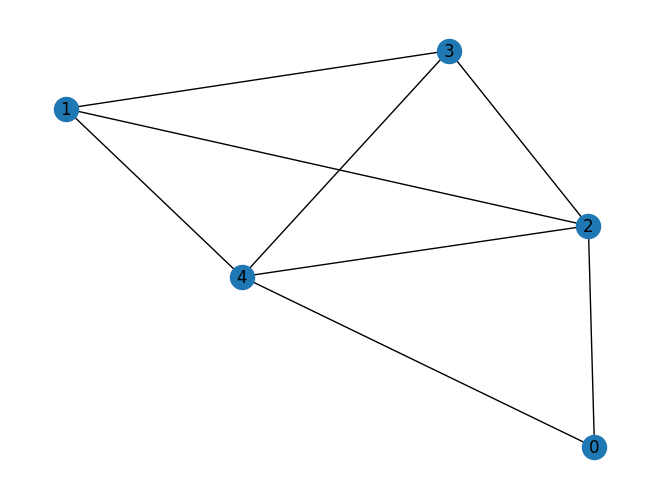

In [31]:
import networkx as nx
from qiskit_optimization.applications import Maxcut  #estas librerias de qiskit tienen helper functions para interpretar resultados

# Make a graph with degree=2 and #node=5
#graph = # crea un grafo regular con parametros (d=2, n=5, seed=111) # https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.random_regular_graph.html#random-regular-graph
graph = nx.erdos_renyi_graph(5,0.8,seed=111) # crea un grafo erdos_renyi_graph con parametros (5, 0.8, seed=111)   #https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html
pos = nx.spring_layout(graph, seed=111)

# Application class for a Max-cut problem
# Make a Max-cut problem from the graph and draw it
maxcut = Maxcut(graph)
maxcut.draw()

In [32]:
# Make a QuadraticProgram by calling to_quadratic_program()
qp = maxcut.to_quadratic_program()
print(qp)

maximize -2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_4 - 2*x_2*x_3 - 2*x_2*x_4 - 2*x_3*x_4 + 2*x_0 + 3*x_1 + 4*x_2 + 3*x_3 + 4*x_4 (5 variables, 0 constraints, 'Max-cut')


### 2 Convertir el `Quadratic Program` a un QUBO y Hamiltoniano de Ising

La clase `QuadraticProgram` es una representación genérica y bastante potente para problemas de optimización.

Sin embargo, los algoritmos cuánticos no no pueden manejar `QuadraticProgram` directamente. Necesitamos convertirlos a problemas de optimización binaria con una formulacion de programa cuadrático binario sin restricciones (QUBO) y quiza tambien como hamiltonianos de Ising:

  - QUBO: formulacion de un problema cadrático binario sin restricciones (Quadratic Unconstrained Binary Optimization)
  - Hamiltoniano de Ising: formulacion de un problema cuadratico Ising como $H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_i Z_j$ donde $Z_i$ es el operador pauli Z

![convertidor](https://raw.githubusercontent.com/qiskit-community/qiskit-application-modules-demo-sessions/cbba1cb845d3f1e0d88f782f288f6c7a78c86a02/qiskit-optimization/images/converter.png)
  
Qiskit ofrece una variedad de [conversores](https://qiskit.org/ecosystem/optimization/apidocs/qiskit_optimization.converters.html) y convierte automáticamente problemas representados en un `QuadraticProgram` a QUBO y Hamiltonianos Ising. 

#### EJERCICIO

Utilizando las funciones de conversion de Qiskit convierte nuestro problema a QUBO y ISING y muestra los modelos obtenidos

In [33]:
#converting to QUBO
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
print("QUBO:")
print(str(qubo)+'\n')

#converting QUBO task to Ising Hamiltonian for simulation on quantum computer
ising, offset = qubo.to_ising()
print("ISING Hamiltonian:")
print(ising)
print(offset)

QUBO:
minimize 2*x_0*x_2 + 2*x_0*x_4 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_1*x_4 + 2*x_2*x_3 + 2*x_2*x_4 + 2*x_3*x_4 - 2*x_0 - 3*x_1 - 4*x_2 - 3*x_3 - 4*x_4 (5 variables, 0 constraints, 'Max-cut')

ISING Hamiltonian:
SparsePauliOp(['IIZIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
-4.0


### 3. Resolver la optimizacion con `MinimumEigenOptimizer`


La funcion [`MinimumEigenOptimizer`](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html) de Qiskit es la rutina para encontrar la solución a un QUBO y su funcionamiento es equivalente a encontrar el estado fundamental (el valor propio mínimo y el vector propio mínimo) del hamiltoniano de Ising correspondiente al problema QUBO.

Esta funcion puede tomar diferentes algoritmos de busqueda de ese valor propio minimo. Nosotros utilizaremos los algoritmos variacionales siguientes:

- [`NumpyMinimumEigensolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.NumPyEigensolver.html): calculo de la solucion con algoritmos numericos clásicos de la librería `numpy`
- `VQE`: Variational Quantum Eigensolver
- `QAOA`: Quantum Approximate Optimizartion Algorithm

Qiskit permite tambien utilizar otros. La informacion sobre la libreria que implementa estos algoritmos puede encontrrse en [qiskit_algorithms](https://qiskit.org/ecosystem/algorithms/apidocs/qiskit_algorithms.html)

Utilizaremos las librerías de `MinimumEigenOptimizer` y de los algoritmos variacionales VQE y QAOA para resolver el problema MaxCut del ejercicio anterior

#### Solucion Clásica

Lo primero usamos computacion clasica para resolver el algoritmo y chequear posteriormente con las soluciones cuánticas.

Hacemos la optimizacion clásica utilizando las librerias numericas de python `numpy`. Esto esta ya programado en Qiskit gracias a la clase `NumPyMinimumEigensolver` a la que podemos pasar una funcion de coste en forma de programa cuadrático (`QuadraticProgram`) y nos devuelve la solucion optima con los datos en un diccionario.

Esta clase, toma el operador hamiltoniano de la funcion de coste y calcula el valor propio minimo de forma numerica clasica. En este caso como necesitamos un Hamiltoniano, tomamos el Hamiltoniano de Ising que hemos obtenido en el paso de convertir el `Quadratic Program` a QUBO y ISING.

#### EJERCICIO

Utiliza el método `compute_minimum_eigenvalue` de la clase [`NumpyMinimumEigensolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.NumPyEigensolver.html) para resolver la optimizacion del operador H (el problema formulado como Ising) , encontrando el vector propio de minima energia.

Convierte en un objeto tipo `Statevector` con el resultado e imprime el diccionario de probabilidades que tiene con el metodo `probabilities_dict()`

In [37]:
from qiskit.quantum_info import Operator

#solve the optimization problem
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(ising)
print('result:\n', result)


#create Statevector with the eigenvector or eigenstate and print the probabilities dictionary
result.eigenstate.probabilities_dict()



result:
 {   'aux_operators_evaluated': None,
    'eigenstate': Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2)),
    'eigenvalue': (-2+0j)}


{'10100': 1.0}

Crea un array que contenga la lista binaria de etiquetas de los nodos ya clasificados tras la optimizacion para dibujar el grafo.

[1 0 1 0 0]


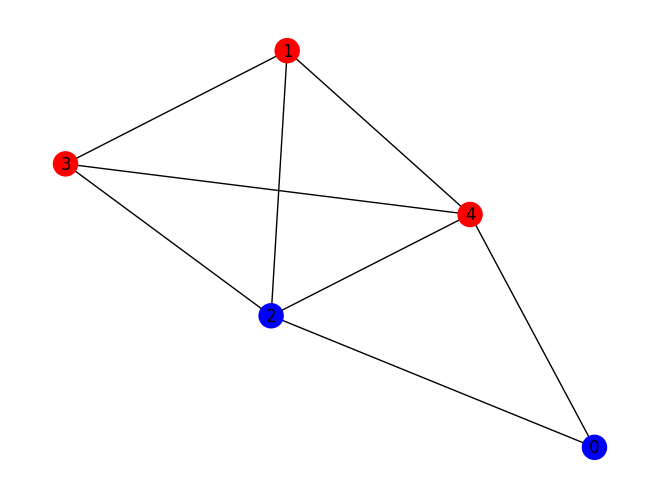

In [40]:
nd=np.array([1,0,1,0,0]) # your code, create a list of labels for nodes of the type array([0,0,1,1,1])
print(nd)
maxcut.draw(nd,pos=pos)

#### VQE

Utilizaremos el algoritmo Variational Quantum Eigensolver (VQE) para resolver el problema MaxCut.

Para ello necesitamos unos pasos previos:

1) Construir un circuito variacional o `Ansatz` con unos parametros. Utilizaremos la clase `TwoLocal` de Qiskit que construye un circuito variacional a conveniencia, con diferentes parametros y configuraciones.

2) Seleccionar una funcion de optimizacion clasica que nos guia para encontrar el minimo.

3) Definimos un backend de ejecucion, un simulador

Después usaremos la clase `VQE` de Qiskit para definir el optimizador y le pasaremos el Ansatz, la funcion de optimizacion y el backend de ejecucion.

Utilizamos la clase `MinimumEigenOptimizer` para lanzar el proceso de optimizacion y le pasaremos la funcion de coste cuadratica del problema que deseamos optimizar para que evalue los costes y encuentre el minimo

Para el primer paso vamos a usar el circuito variacional [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html). En principio, si no se tiene informacion sobre el espacio de estados que ha de buscarse, se construye un circuito heurístico de este tipo que suele dar buenso resultados. La versatilidad de su configuracion, nos permite crear un espacio de busqueda de estados muy amplio. Tambien hay que tener en cuenta que hay siempre un compromiso en la eleccion del numero de parametros de busqueda que si por ejemplo, es muy alto nos dará mas precision en la solucion pero menor velocidad de convergencia.

Probamos varios circuitos `TwoLocal` y podemos probar varias configuraciones para ver el tipo de cirsuitos que genera.

20


/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


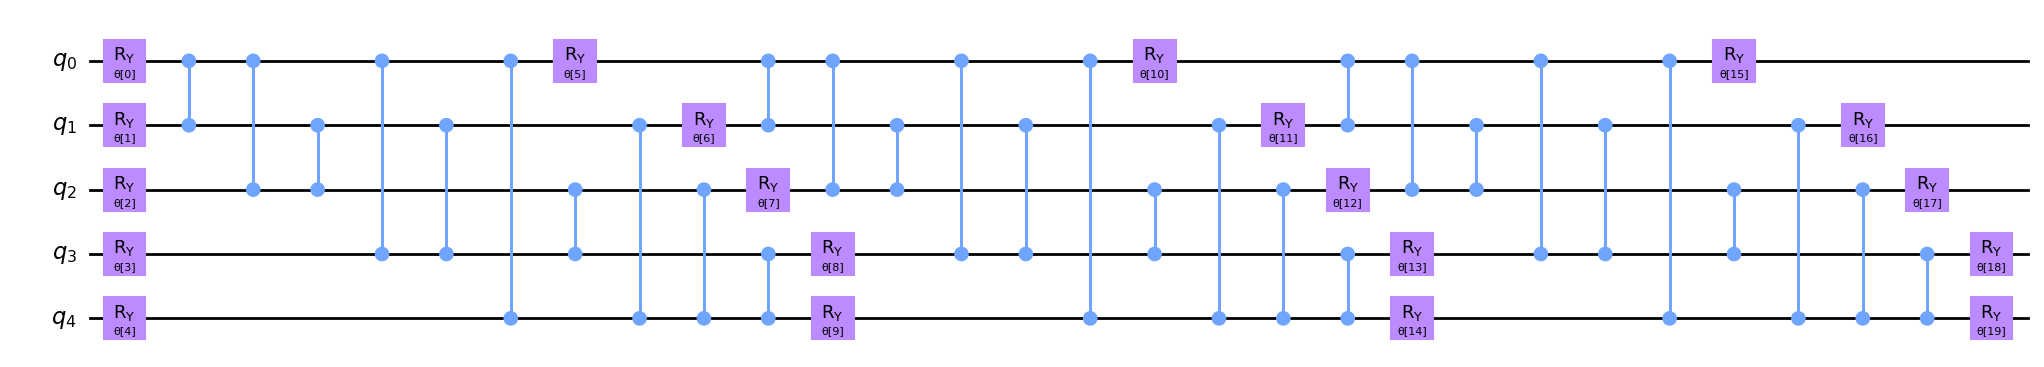

In [42]:
n=5
#ansatz = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
ansatz =TwoLocal(n, "ry", "cz", reps=3, entanglement="full")
print(ansatz.num_parameters)
ansatz.decompose().draw("mpl",fold=-1)

Resolveremos ahora el problema de optimizacion con la clase [`SamplingVQE`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQE.html#qiskit_algorithms.SamplingVQE) y las librerías `Runtime`

En este caso necesitamos un Hamiltoniano, así que tomamos el Hamiltoniano de Ising que hemos optenido en el paso de convertir el `Quadratic Program` a QUBO y ISING.

#### EJERCICIO

Utiliza el método `compute_minimum_eigenvalue()` de la clase [`SamplingVQE`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQE.html#qiskit_algorithms.SamplingVQE) para resolver la optimizacion del operador H (el problema formulado como Ising), encontrando el vector propio de minima energia.

Investiga la clase de resultado que devuelve este algoritmo [SamplingVQEResult](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQEResult.html) y utilizando el metodo `best_measuretments()` imprime el resultado binario y dibuja el grafo obteindo de la minimizacion.

SamplingMinimumEigensolverResult:
	Eigenvalue: -2.0
	Best measurement
: {'state': 20, 'bitstring': '10100', 'value': (-2+0j), 'probability': 0.46875}

[1 0 1 0 0]


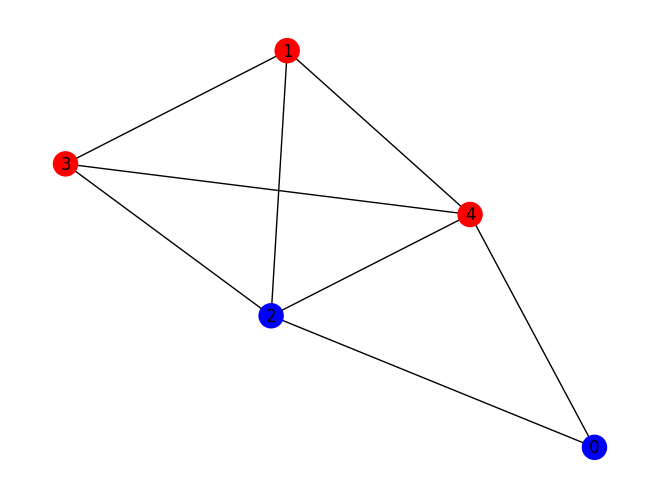

In [47]:
ansatz = TwoLocal(n, 'ry', 'cz')
opt = SPSA(maxiter=50)
 
# shot-based simulation
sampler = Sampler(options={"shots": 2048})
vqe = SamplingVQE(sampler, ansatz, opt, aggregation=0.2)

#find min eigenvalue
result = vqe.compute_minimum_eigenvalue(ising)
print(result)

#display results in the graph
nd=np.array([1,0,1,0,0]) # your code, create a list of labels for nodes of the type array([0,0,1,1,1])
print(nd)
maxcut.draw(nd,pos=pos)

Tenemos la resolucion del VQE que nos da tambien los parametros del `Ansatz` que construyen el estado que minimiza la energia y podemos encontrar el estado a partir del circuito parametrico. Para ello lo calculamos a partir de los resultados del algoritmo. Vease la clase [SamplingVQEResult](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQEResult.html) donde estan los metodos que necesitamos para este calculo

#### EJERCICIO

Investiga la estructura de la clase de los resultados ejecutando la instruccion `dir(result)`

Muestra el circuito variacional optimo que ha encontrado el optimizador, ejecuta el circuito y muestra el histograma de salida, para ver el estado optimo que hemos encontrado

In [48]:
dir(result)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_aux_operator_values',
 '_best_measurement',
 '_cost_function_evals',
 '_eigenstate',
 '_eigenvalue',
 '_optimal_circuit',
 '_optimal_parameters',
 '_optimal_point',
 '_optimal_value',
 '_optimizer_evals',
 '_optimizer_result',
 '_optimizer_time',
 'aux_operators_evaluated',
 'best_measurement',
 'combine',
 'cost_function_evals',
 'eigenstate',
 'eigenvalue',
 'optimal_circuit',
 'optimal_parameters',
 'optimal_point',
 'optimal_value',
 'optimizer_evals',
 'optimizer_result',
 'optimizer_time']

/tmp/ipykernel_24067/1479719873.py:1: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  result.optimal_circuit.bind_parameters(result.optimal_parameters).decompose().draw("mpl",fold=-1)
/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


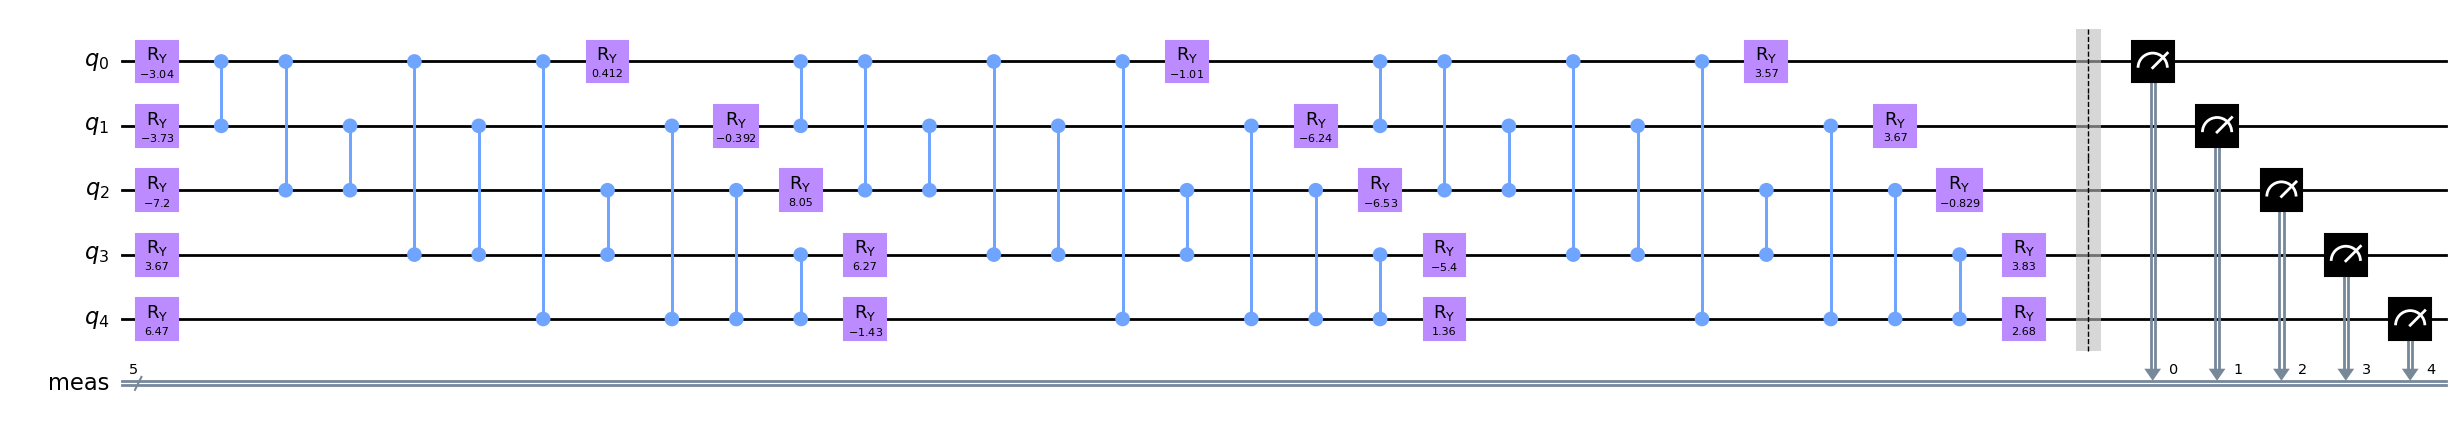

In [53]:
result.optimal_circuit.bind_parameters(result.optimal_parameters).decompose().draw("mpl",fold=-1)

/tmp/ipykernel_24067/824299411.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)


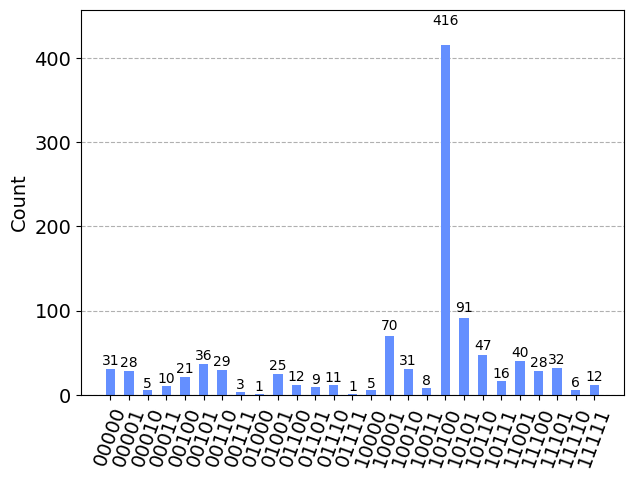

In [54]:
#podemos ver el circuito optimo

#podemos ejecutarlo, uno de esos estados que ha muestreado el circuito variacional ha dado minima energia
circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)

# Hacemos un transpile del circuito para el simulador
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circuit, simulator)  #opcional

# lo corremos y obtenemos los resultados
job = simulator.run(circ).result()
plot_histogram(job.get_counts())


#### QAOA

Utilizaremos el algoritmo Qantum Approximate Optimization Algorithm (QAOA) para resolver el problema de MaxCut. Este es otro algoritmo que utiliza un circuito variacional definido internamente y no necesitamos crear ningun `Ansatz`explicitamente.

Para ejecutarlo necesitamos los pasos previos anteriores:

1) Seleccionar una funcion de optimizacion clasica que nos guia para encontrar el minimo.

2) Definimos un backend de ejecucion, un simulador

Después usaremos la clase `QAOA` de Qiskit para definir el optimizador y le pasaremos la funcion de optimizacion y el backend de ejecucion. Tambien tendremos que especificar el numero de repeticiones que ejecutaremos en el algoritmo `QAOA`.

Utilizamos la clase `MinimumEigenOptimizer` para lanzar el proceso de optimizacion y le pasaremos la funcion de coste cuadratica del problema que queremos optimizar para que evalue los costes y encuentre el minimo

#### EJERCICIO

Utiliza el método `compute_minimum_eigenvalue()` de la clase [`QAOA`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) para resolver la optimizacion del operador H (el problema formulado como Ising), encontrando el vector propio de minima energia.

La clase `QAOA` se contruye a partir de la clase `SamplingVQE`por lo que devuelve la misma clase de resultados, [SamplingVQEResult](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQEResult.html). Utiliza el metodo `best_measuretments()` imprime el resultado binario y dibuja el grafo obteindo de la minimizacion.

In [55]:
# shot-based simulation
sampler = Sampler()
 
optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2) #include number of repetitions for QAOA
 
#find min eigenvalue
result = qaoa.compute_minimum_eigenvalue(ising)#yout code
print(result)

#display results in the graph
#nd= #your code
#print(nd)
#maxcut.draw(nd,pos=pos)

SamplingMinimumEigensolverResult:
	Eigenvalue: -0.8918058469795314
	Best measurement
: {'state': 11, 'bitstring': '01011', 'value': (-2+0j), 'probability': 0.2158356333423898}



#### EJERCICIO

Muestra el circuito variacional optimo que ha encontrado el optimizador, ejecuta el circuito y muestra el histograma de salida, para ver el estado optimo que hemos encontrado

In [ ]:
#podemos ver el circuito optimo

#podemos ejecutarlo, uno de esos estados que ha muestreado el circuito variacional ha dado minima energia
circuit = 

# Hacemos un transpile del circuito para el simulador
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circuit, simulator)  #opcional

# lo corremos y obtenemos los resultados
